## 1. Introduction

This project analyzes the **Architectural, Engineering and Related Services Price Index (AESPI)**, a dataset published by Statistics Canada that tracks pricing in key professional service sectors across Canadian regions.

<strong>Data Source</strong>: 
<a href="https://ouvert.canada.ca/data/dataset/44c6bf5b-8532-4336-83ed-d64d9dbaaa14" target="_blank">Open Canada Dataset</a> |
<a href="https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810016401" target="_blank">CANSIM Table 18100164</a>

**Coverage**:
Q1 2013 to Q4 2024

The goal is to extract valuable insights by identifying **patterns, regional differences, and time-based pricing trends**. Specifically, the following questions will be addressed:

- How have architectural and engineering service prices evolved over time in Canada?  
- How do prices vary across different regions?  
- Are there any significant changes or trends that stand out and deserve attention?

These insights can help organizations—particularly those in cost-sensitive sectors—optimize procurement strategies, budgeting, and financial planning.

This project applies a range of data science techniques to analyze pricing trends, including:  
- **Time-series line plots** to track quarterly price evolution across services and regions
- **Comparative bar charts** highlighting year-over-year percentage changes
- **Heatmap analysis** of cumulative regional price changes
- An **interactive dashboard** (built with Plotly Dash) with **choropleth mapping** and **dynamic filters** for service/region/time period.


The analysis leverages `pandas` for data preparation and `seaborn/matplotlib` for visualization, following Statistics Canada's standardized pricing methodology. Let’s load the required libraries and get started.

In [3]:
# System and File Utilities
import os
os.makedirs("../analysis/figures", exist_ok=True)
os.makedirs("../assets", exist_ok=True)

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import missingno as msno

---

## 2. Data Loading and Preparation

### 2.1. Data Source and Loading

The dataset was sourced from Statistics Canada's quarterly AESPI release (CANSIM Table 18100164), covering Q1 2013 to Q4 2024. The raw CSV data was loaded into a **`pandas` DataFrame** for exploration and analysis:

In [6]:
# Load dataset
aespi_raw = pd.read_csv("../data/raw/18100164.csv")

# Display first rows
aespi_raw.head(3)

,REF_DATE,GEO,DGUID,North American Industry Classification System (NAICS),UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2013-01,Canada,2016A000011124,"Architectural, engineering and related service...",2018=100,390,units,0,v1064338901,1.1,101.4,NaN,NaN,NaN,1
1,2013-01,Canada,2016A000011124,Architectural and landscape architectural serv...,2018=100,390,units,0,v1064338907,1.2,88.9,NaN,NaN,NaN,1
2,2013-01,Canada,2016A000011124,Engineering services,2018=100,390,units,0,v1064338913,1.3,103.5,NaN,NaN,NaN,1


---

### 2.2. Dataset Overview

The AESPI dataset contains quarterly price index data for architectural, engineering, and related services across Canadian regions, categorized by the **NAICS (North American Industry Classification System)**—the standard used to classify business establishments based on their economic activities.

Each row in the dataset represents a unique observation for a given combination of:

- **REF_DATE** (Reference Date): The year and quarter of the observation.
- **GEO** (Geography): The region where the service is reported.
- **NAICS** (North American Industry Classification System): The code representing the professional service classification.
- **VALUE:** The price index, where 2018 is the base year (set to 100). Values above 100 indicate higher prices than in 2018, while values below 100 indicate lower prices.

Additional columns include:

- DGUID (Dissemination Geography Unique Identifier): A unique code assigned to a dissemination geography, as defined in Statistics Canada’s Common Output Database Repository (CODR).
- UOM (Unit of Measure): Indicates the measurement unit for the price index; in this dataset, every record is standardized to "2018=100," meaning 2018 is used as the base year.
- UOM_ID: An identifier for the unit of measure.
- SCALAR_FACTOR and SCALAR_ID: Indicate how the recorded values should be scaled. In this dataset, they consistently show “units” and “0,” respectively, offering no additional insight for the current analysis.
- VECTOR, COORDINATE, STATUS, SYMBOL, TERMINATED, and DECIMALS: Internal-use or formatting-related fields that won’t be used in this analysis.

---

### 2.3. Data Preparation

#### 2.3.1. Data Selection and Transformation

Before conducting the analysis, I refined the dataset to focus on the variables essential for examining geographic trends and price indices. For this project, I **preserved the following information**:

- **REF_DATE** (Reference Date)
- **GEO** (Geography)
- **NAICS** (North American Industry Classification System)
- **VALUE** (Price Index)

All **additional columns were dropped** because they are not necessary for this study:

In [10]:
# Remove columns
columns_to_remove = ["DGUID", "UOM", "UOM_ID", "SCALAR_FACTOR", "SCALAR_ID", "VECTOR", "COORDINATE", "STATUS", "SYMBOL", "TERMINATED", "DECIMALS"]
aespi = aespi_raw.drop(columns=columns_to_remove)

To enhance clarity, I opted to **rename the remaining columns**, providing a cleaner, context-appropriate presentation:

In [12]:
# Rename columns
aespi = aespi.rename(columns={
    "REF_DATE": "Date",
    "GEO": "Region",
    "North American Industry Classification System (NAICS)": "Service Category",
    "VALUE": "Index Value"
})

Here are the cleaned column names and their definitions for the data used in this analysis:

<div style="text-align: center">

#### **Table 1: Data Dictionary**  

</div>

| Column Name (Raw) | Column Name (Clean) | Description |  
|-------------------|---------------------|-------------|  
| `REF_DATE` | `Date` | Year and quarter of observation (e.g., `2023-01` for Q1 2023) |  
| `GEO` | `Region` | Geographic region (e.g., "Quebec", "Prairie Region") |  
| `North American Industry Classification System (NAICS)` | `Service Category` | Type of service (e.g., "Engineering services") |  
| `VALUE` | `Index Value` | Price index (2018 = 100). Values >100 indicate higher prices than 2018. |  
<br>

After simplifying the dataset, I verified the DataFrame structure by **checking the data types** of the remaining columns:

In [16]:
# Check data types
print(aespi.dtypes)

Date                 object
Region               object
Service Category     object
Index Value         float64
dtype: object


I converted the "Date" column from object to **datetime type** to enable time-based operations (such as grouping by quarter or filtering by date range):

In [18]:
# Convert Date to datetime
aespi["Date"] = pd.to_datetime(aespi["Date"])

Since the **Region** and **Service Category** columns have a limited set of unique values, I converted them to **categorical types** for efficient storage and consistent ordering. Both columns were **reordered** following the ordering used on the Statistics Canada website—with the aggregate "Architectural, engineering and related services price index" category appearing first.

In [20]:
# Define the desired order for Region
region_order = [
    "Canada", 
    "Atlantic Region", 
    "Quebec", 
    "Ontario", 
    "Prairie Region", 
    "British Columbia and territories"
]

# Convert Region to an ordered categorical variable
aespi["Region"] = pd.Categorical(aespi["Region"], categories=region_order, ordered=True)

# Define the desired order for Service Category
service_order = [
    "Architectural, engineering and related services price index",
    "Architectural and landscape architectural services",
    "Engineering services",
    "Surveying and mapping services"
]

# Convert Service Category to an ordered categorical variable
aespi["Service Category"] = pd.Categorical(aespi["Service Category"], categories=service_order, ordered=True)

Now that the data types are properly optimized for our analysis, we can move on to the data validation and standardization stage.

### 2.3.2. Data Validation & Standardization

This **overview of the refined dataset** displays the first few rows, its dimensions, and a summary of the data structure:

In [24]:
# Display the first rows
aespi.head()

,Date,Region,Service Category,Index Value
0,2013-01-01,Canada,"Architectural, engineering and related service...",101.4
1,2013-01-01,Canada,Architectural and landscape architectural serv...,88.9
2,2013-01-01,Canada,Engineering services,103.5
3,2013-01-01,Canada,Surveying and mapping services,98.9
4,2013-01-01,Atlantic Region,Architectural and landscape architectural serv...,NaN


In [25]:
# Show the number of rows and columns
print(aespi.shape)

(1052, 4)


In [26]:
# Display a summary of the DataFrame
print(aespi.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052 entries, 0 to 1051
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1052 non-null   datetime64[ns]
 1   Region            1052 non-null   category      
 2   Service Category  1052 non-null   category      
 3   Index Value       752 non-null    float64       
dtypes: category(2), datetime64[ns](1), float64(1)
memory usage: 19.0 KB
None


Notice that the "Index Value" column has only **752 non-null entries out of 1052 rows**, indicating **missing values** that will be investigated in the following section. First, I'll examine the **distribution** of values in each column to confirm there are no other unexpected values, duplicates, or inconsistencies.

In [28]:
# Check the range of dates
print("Date range:", aespi["Date"].min(), "to", aespi["Date"].max())

Date range: 2013-01-01 00:00:00 to 2024-10-01 00:00:00


The output showing a date range from **2013-01-01** to **2024-10-01** aligns well with the dataset description. This confirms that the dataset covers the expected time span.

In [30]:
# Check Region column
print("Unique Regions:", aespi["Region"].unique())
print(aespi["Region"].value_counts())

Unique Regions: ['Canada', 'Atlantic Region', 'Quebec', 'Ontario', 'Prairie Region', 'British Columbia and territories']
Categories (6, object): ['Canada' < 'Atlantic Region' < 'Quebec' < 'Ontario' < 'Prairie Region' < 'British Columbia and territories']
Region
Canada                              192
Atlantic Region                     172
Quebec                              172
Ontario                             172
Prairie Region                      172
British Columbia and territories    172
Name: count, dtype: int64


The **unique values** in the "Region" column **match the dataset description**. Five regions each have **172** observations, while the national-level entry "Canada" has **192**, that is, 20 more than the individual regions. This discrepancy suggests there may be differences in how national data is reported or aggregated compared to regional data, but further investigation is needed.

In [32]:
# Check Service Category column
print("Unique Service Categories:", aespi["Service Category"].unique())
print(aespi["Service Category"].value_counts())

Unique Service Categories: ['Architectural, engineering and related servic..., 'Architectural and landscape architectural ser..., 'Engineering services', 'Surveying and mapping services']
Categories (4, object): ['Architectural, engineering and related servic... < 'Architectural and landscape architectural ser... < 'Engineering services' < 'Surveying and mapping services']
Service Category
Architectural and landscape architectural services             288
Engineering services                                           288
Surveying and mapping services                                 288
Architectural, engineering and related services price index    188
Name: count, dtype: int64


The **unique values** in the service categories also **align with the dataset description**, and no anomalies were observed in this regard. While each of the first three categories  have the same number of entries (**288**), the "Architectural, engineering and related services price index" has **188** observations. Further investigation is warranted to clarify why this discrepancy exists and how it might impact subsequent analyses.

In [34]:
# Check Index Value column
print(aespi["Index Value"].describe())
print("Missing values in Index Value:", aespi["Index Value"].isnull().sum())

count    752.000000
mean     107.415160
std        8.996359
min       88.900000
25%      101.075000
50%      103.900000
75%      112.325000
max      139.200000
Name: Index Value, dtype: float64
Missing values in Index Value: 300


The summary statistics for the "Index Value" column show a **minimum of 88.9** and a **maximum of 139.2**, with a mean of approximately 107.4 and a standard deviation of about 9. Since the **values are standardized** to a common scale (2018=100), this ensures a fair comparison across groups. There is no reason to suspect anomalies at this stage, and further investigation will be conducted during the EDA phase.

Now let's verify that the dataset doesn't contain **duplicate entries** for each combination each combination of "Date", "Region, and "Service Category":

In [36]:
# Check for duplicate rows
duplicates = aespi.duplicated(subset=["Date", "Region", "Service Category"], keep=False)

# Count duplicates
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


The duplicate check confirmed that there are **no multiple records** for any given combination of "Date", "Region", and "Service Category", so we can move on to the next phase of our analysis.

#### 2.3.3. Missing Data Analysis

In this section, I will:

- **Quantify missing values:** Confirm the number of missing values in each column.
- **Examine distribution patterns:** Explore how missing data is distributed to detect systematic gaps.
- **Investigate discrepancies:** Identify potential causes for the differences in record counts among regions and service categories observed earlier.
- **Develop a cleaning strategy:** Determine an appropriate approach for handling missing values based on these insights.


Let's begin by examining the number of missing values in each column:

In [39]:
# Check the number of missing values per column
print(aespi.isnull().sum())

Date                  0
Region                0
Service Category      0
Index Value         300
dtype: int64


In [40]:
# Display the percentage of missing values per column
print((aespi.isnull().mean() * 100).round(2))

Date                 0.00
Region               0.00
Service Category     0.00
Index Value         28.52
dtype: float64


The Index Value column has **28.52%** missing values. Let's use **msno.matrix** to **visualize the missing data patterns** across the dataset:

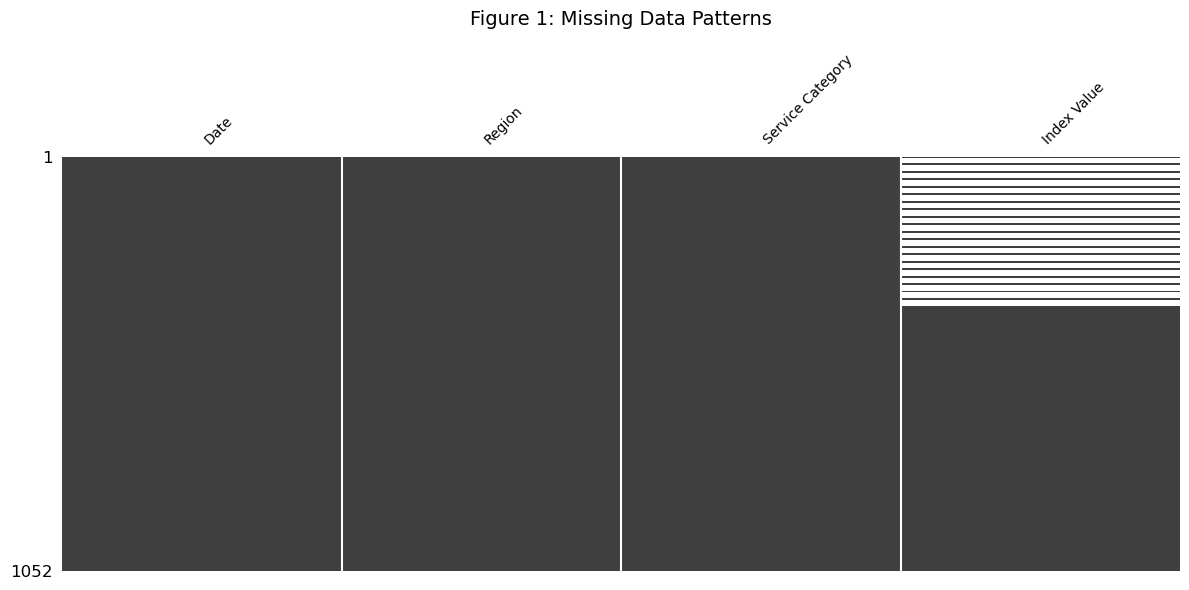

In [42]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Generate the missingno plot
msno.matrix(
    aespi,
    sparkline=False,
    fontsize=10,
    ax=ax
)

# Set title
ax.set_title("Figure 1: Missing Data Patterns", pad=20, fontsize=14)

# Export and show
plt.tight_layout()
plt.savefig('../analysis/figures/missing_data.png', 
           dpi=300, 
           bbox_inches='tight')
plt.show()

The missingno matrix shows that **missing values** in the `Index Value` column are all concentrated in the **earliest dates**, while the middle and final periods have complete data.

Looking back at the raw CSV file, it was clear that the period from **2013 to 2017** contained Price Index values only for Canada, not for specific regions. Therefore, a decision had to be made: retain data from that period or not. I chose to focus the analysis on the most recent dates—from **January 2018 to October 2024**—not only because it is more recent, but also because it includes data for all regions.

Thus, let's **drop all rows with dates from 2013 to 2017**:

In [44]:
# Drop rows where the date is before January 1, 2018
aespi = aespi[aespi["Date"] >= "2018-01-01"]

The **updated DataFrame** looks like this:

In [46]:
aespi

,Date,Region,Service Category,Index Value
380,2018-01-01,Canada,"Architectural, engineering and related service...",99.5
381,2018-01-01,Canada,Architectural and landscape architectural serv...,99.3
382,2018-01-01,Canada,Engineering services,99.5
383,2018-01-01,Canada,Surveying and mapping services,99.9
384,2018-01-01,Atlantic Region,"Architectural, engineering and related service...",100.0
...,...,...,...,...
1047,2024-10-01,Prairie Region,Surveying and mapping services,106.1
1048,2024-10-01,British Columbia and territories,"Architectural, engineering and related service...",135.5
1049,2024-10-01,British Columbia and territories,Architectural and landscape architectural serv...,121.6
1050,2024-10-01,British Columbia and territories,Engineering services,137.7


Let's confirm that the dataset has **no more missing values** and evaluate how the **record counts** for service categories and regions have been affected.

In [48]:
# Check for missing values in the dataset
print(aespi.isnull().sum())

Date                0
Region              0
Service Category    0
Index Value         0
dtype: int64


In [49]:
# Check Region column
print(aespi["Region"].value_counts())

Region
Canada                              112
Atlantic Region                     112
Quebec                              112
Ontario                             112
Prairie Region                      112
British Columbia and territories    112
Name: count, dtype: int64


In [50]:
# Check Service Category column
print(aespi["Service Category"].value_counts())

Service Category
Architectural, engineering and related services price index    168
Architectural and landscape architectural services             168
Engineering services                                           168
Surveying and mapping services                                 168
Name: count, dtype: int64


After a thorough review and targeted cleaning, all **missing values have been successfully addressed**. The discrepancies in record counts among regions and service categories were driven by incomplete data between 2013 and 2017. With these gaps resolved, the dataset now reflects consistent counts across all groups. Since data integrity has been confirmed, we can save a clean copy of the dataset for reproducibility and proceed to the analysis stage.

In [52]:
# Final cleaned dataset
aespi.to_csv("../data/processed/aespi_clean.csv", index=False)

---

## **3. Exploratory Data Analysis (EDA)**

This section examines how the Price Index evolves across service categories and regions, with two key objectives:  

1. **Pattern Identification**:  
   - Validate data quality
   - Compare trends between services and regions
   <br><br>
2. **Contextual Insights**:  
   - Link observed patterns to potential drivers (e.g., infrastructure investments, policy changes)  
   - Highlight anomalies coinciding with economic events  

### 3.1 Time Series Trends by Service and Region

The visual analysis begins with time-series line plots to reveal how service prices evolved quarterly from 2018–2024.

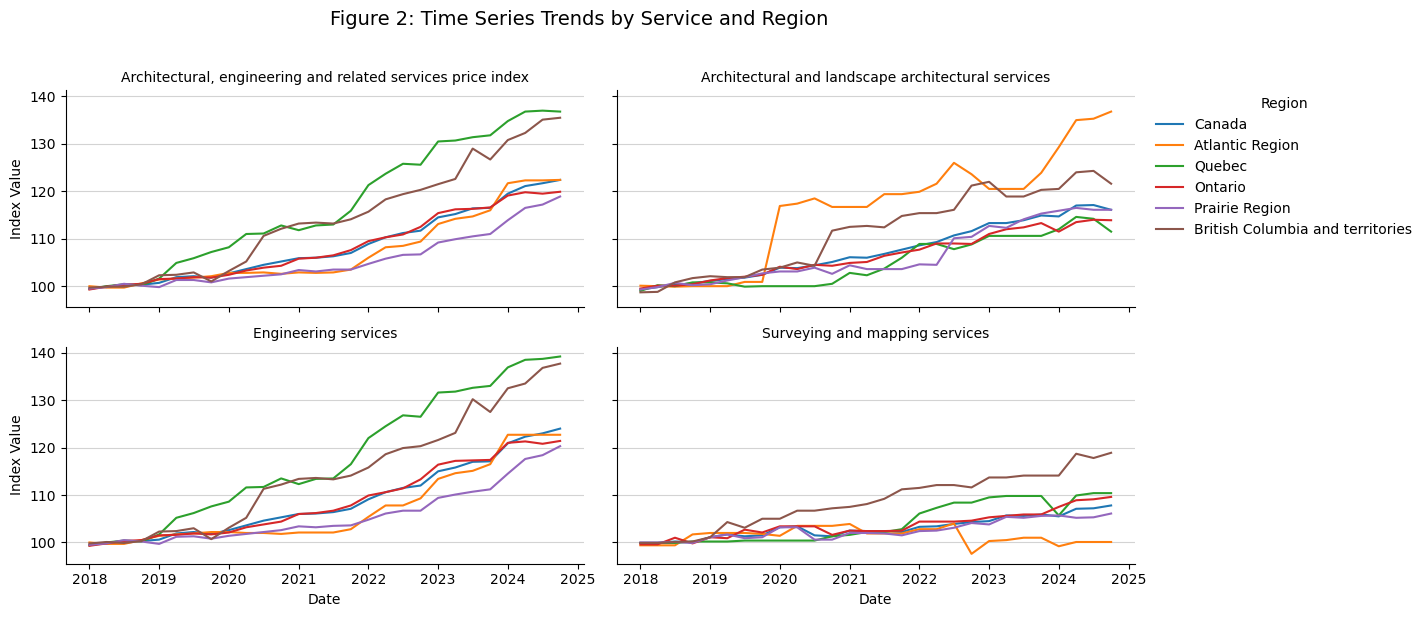

In [57]:
# Create line plots per Service Category and Region
g = sns.relplot(
    data=aespi,
    x="Date",
    y="Index Value",
    hue="Region",
    kind="line",
    col="Service Category",
    col_wrap=2,
    height=3,
    aspect=1.5,
    facet_kws={"sharey": True}
)

# Add title
g.fig.suptitle("Figure 2: Time Series Trends by Service and Region", y=1.02, fontsize=14)

# Display the category name
g.set_titles(col_template="{col_name}")

# Move the legend
g._legend.set_bbox_to_anchor((1.22, 0.75))

# Add horizontal gridlines
for ax in g.axes.flat:
    ax.grid(True, axis="y", color="lightgray")

g.savefig('../analysis/figures/time_series.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

#### 3.1.1. Sanity Check

To provide a reality check and establish a reference baseline for our analysis, we will compare our observed price index values with an external measure, the Consumer Price Index (CPI). The **CPI**, which measures the average change in prices for a basket of goods and services, indicates that overall prices in Canada have increased by roughly 20% from 2018 to 2024. In practical terms, if prices were normalized to 100 in 2018, they would be expected to be around **120** in 2024, allowing for some natural variability.

In the top left line plot, the **"Architectural, engineering and related services price index"** for Canada reaches approximately **122** by the end of the period. This aggregate index—comprising Architectural and landscape architectural services, Engineering services, and Surveying and mapping services—closely matches the expected value based on the CPI. Meanwhile, the remaining service category values fall within an approximate range of **100 to 140**, suggesting that the magnitude of our data is consistent with external expectations and that there is **no reason to suspect the presence of extraneous values**.

#### 3.1.2. Trends and Patterns

##### 3.1.2.1. Services Analysis by Region

Our time series plots reveal several noteworthy trends in service prices across different regions and service categories:

- **General Trends:**  
  Most service categories exhibit an overall tendency for price increases throughout the period. However, **Surveying and mapping services** in the **Atlantic Region** show almost no increase over time. Moreover, this particular category displays a less accentuated rise in other regions as well when compared to the other service categories.

- **Notable Peaks:**  
  - **Architectural and landscape architectural services** in the **Atlantic Region** display a remarkable peak near the **end of 2019**. This early peak aligns with broader economic trends (e.g., infrastructure investments and labor shortages reported in 2019 by StatCan). A second surge occurred from **mid-2023 to early 2024**, coinciding with:  
      - Federal affordable housing investments (\$4B announced in 2023)
      - Post-Hurricane Fiona coastal resilience projects 
      - Hospital construction booms (e.g., Halifax Infirmary redevelopment)
        <br>
  - In **British Columbia and territories**, both **Architectural and landscape architectural services** and **Engineering services** reveal a distinct peak around mid-2020. This surge may reflect pre-pandemic project pipelines and acute regional labor shortages (e.g., StatCan 2020 reports on BC construction demand).
<br><br>
- **Downward Trends:**  
  - The most noticeable downward trend is observed in **Surveying and mapping services** in the **Atlantic Region**, particularly around mid-2022. This decline could be the result of post-COVID demand softening, construction delays related to inflation, severe weather disruptions, and a transitional period between completed stimulus projects and new funding cycles.
  - Additionally, there is a hint of a downward movement in **Architectural and landscape architectural services** in most regions (except for the Atlantic Region) as of mid-2024. The dip coincides with Bank of Canada rate hikes (2023–2024); monitoring Q3 2024 data will clarify if this is a trend reversal.


##### 3.1.2.2. Comparison between Regions

When comparing regions, the plots indicate that **Quebec** and the combined region of **British Columbia and territories** experienced the most marked increases in **Engineering services** and **Surveying and mapping services** prices. In these regions, the price indices are noticeably higher than in others, as reflected in the aggregate “Architectural, engineering and related services price index” shown in the top left plot. These regional differences may be driven by factors such as major infrastructure initiatives (e.g., Montréal’s REM and Kitimat’s LNG Canada projects), climate adaptation needs, and acute skilled labor shortages.


Let's carry out subsequent analyses to delve deeper into the regional and service-specific differences and extract more insights.

---

### 3.2. Year-Over-Year Changes by Region and Service

In this section, we examine the **annual changes** in the service price index **by region** using a **combined bar and line plot**. 

The **bars** represent the year-over-year percentage changes for the **individual service categories**, while the **aggregate index** (Architectural, engineering and related services price index) is overlaid as a **line**.

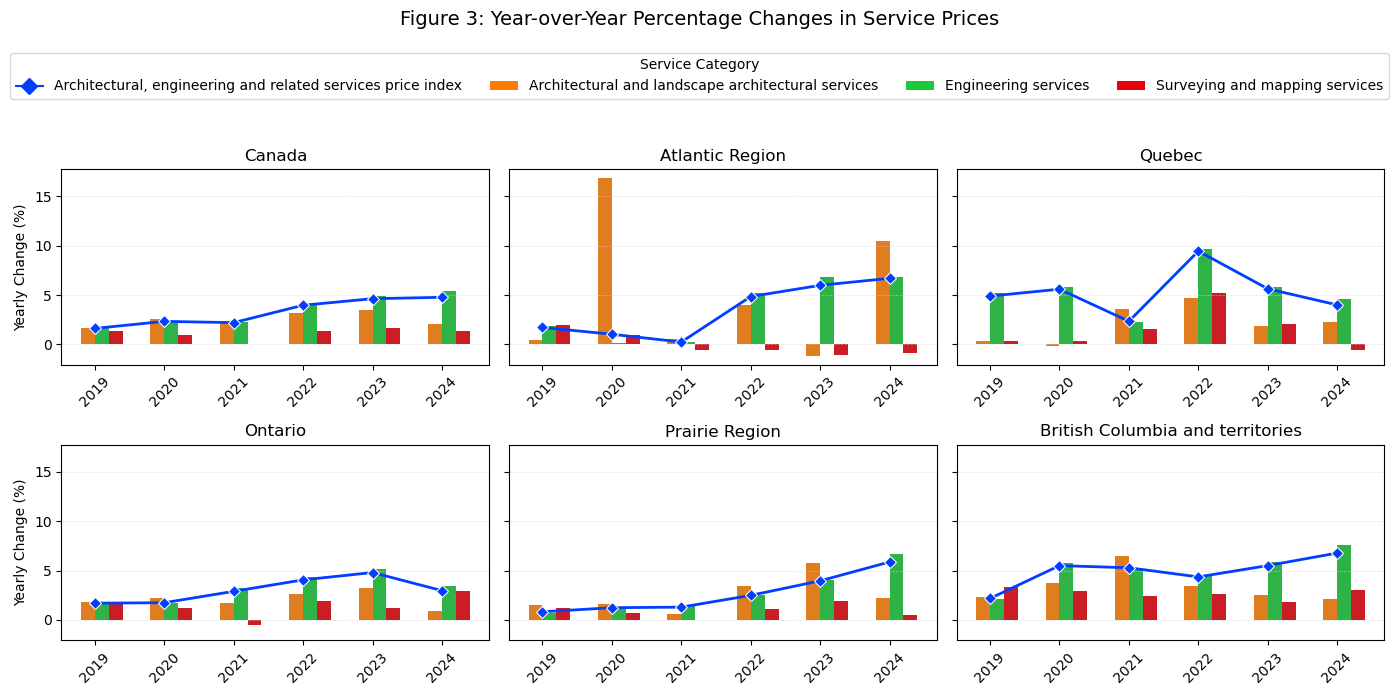

In [63]:
# Create a Year column from Date
aespi["Year"] = aespi["Date"].dt.year

# Compute annual average index value
annual_avg = aespi.groupby(["Region", "Service Category", "Year"], observed=False)["Index Value"].mean().reset_index()

# Compute year-over-year percentage change
annual_avg["Yearly Change (%)"] = annual_avg.groupby(["Region", "Service Category"], observed=False)["Index Value"].pct_change() * 100

# Remove NaN values produced by pct_change (first data point)
annual_change = annual_avg.dropna(subset=["Yearly Change (%)"]).reset_index(drop=True)

# Split data to create line vs. bar plots
line_data = annual_change[annual_change["Service Category"] == "Architectural, engineering and related services price index"]
bar_data = annual_change[annual_change["Service Category"].isin([
    "Architectural and landscape architectural services",
    "Engineering services", 
    "Surveying and mapping services"
])]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 6), sharey=True)
axes = axes.flatten()

# Get consistent colors
all_categories = annual_change["Service Category"].unique()
palette = sns.color_palette("bright", len(all_categories))
color_map = {category: color for category, color in zip(all_categories, palette)}

# Create proxy artists for legend
handles = []
for category in all_categories:
    if category == "Architectural, engineering and related services price index":
        handles.append(Line2D([0], [0], color=color_map[category], marker="D", linestyle="-", 
                            markersize=8, label=category))
    else:
        handles.append(plt.Rectangle((0,0), 1, 1, fc=color_map[category], label=category))

for ax, region in zip(axes, annual_change["Region"].unique()):
    # Plot bars
    region_bar_data = bar_data[bar_data["Region"] == region]
    sns.barplot(
        data=region_bar_data,
        x="Year",
        y="Yearly Change (%)",
        hue="Service Category",
        palette=color_map,
        errorbar=None,
        ax=ax
    )
    
    # Plot line
    region_line_data = line_data[line_data["Region"] == region]
    years = sorted(region_line_data["Year"].unique())
    x_pos = np.arange(len(years))
    
    sns.lineplot(
        x=x_pos,
        y=region_line_data["Yearly Change (%)"],
        color=color_map["Architectural, engineering and related services price index"],
        marker="D",
        linewidth=2,
        ax=ax,
        label="Architectural, engineering and related services price index"
    )
    
    # Formatting
    ax.set_title(region)
    ax.set_xlabel("")
    ax.set_ylabel("Yearly Change (%)")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(years)
    ax.tick_params(axis="x", rotation=45)
    ax.grid(True, axis="y", color="lightgray", linestyle="--", linewidth=0.5, alpha=0.6)
    ax.get_legend().remove()

# Create legend
fig.legend(handles=handles, labels=all_categories, title="Service Category", 
           loc="upper center", bbox_to_anchor=(0.5, 1.09), ncol=4)

# Add title
plt.suptitle("Figure 3: Year-over-Year Percentage Changes in Service Prices", y=1.15, fontsize=14)

plt.tight_layout()
plt.savefig('../analysis/figures/yearly_changes.png', dpi=300, bbox_inches='tight')
plt.show()

#### 3.2.1. Canada: Nationwide Growth Patterns 
The national-level data (top-left plot) shows that **prices rose every year across all service categories**, as all year-over-year changes were positive.
  - **Engineering services lead price increases**, likely driven by:
    - Nationwide infrastructure projects
    - Labor/material cost pressures
  - **Architectural services** show **moderate increase**, reflecting:
    - Housing market fluctuations
    - Institutional/non-residential projects
  - **Surveying/mapping trail other sectors**, consistent with:
    - Construction investment declines
    - Commodity market volatility

#### 3.2.2. Atlantic Region: Bimodal Peaks
The bar plot validates the time series trends from Figure 2, since **Architectural services** show two peaks (2020 and 2024), highlighting a possible association with major regional investments.  

#### 3.2.3. Quebec: Engineering-Driven Volatility
- Both the **aggregate index** (blue line) and the **Engineering services** category show pronounced changes—each reached nearly a 10% difference in 2022.  
- Potential drivers include:  
  - Mega-projects (e.g., REM, hospital developments)  
  - Severe engineering shortages  
  - Material supply disruptions  
  - Stricter climate codes leading to costly redesigns  

#### 3.2.4. Ontario & Prairie Region: Stable Growth Profile
- Aggregate index consistently below **+5% YoY** across all years  
- Exception: Prairie's **2024 surge** likely reflects:  
  - Energy sector investments (oil sands, carbon capture projects)  
  - Agricultural infrastructure modernization  

#### 3.2.5. British Columbia & Territories: Sustained Premium Pricing
- Baseline increase anchored near **+5% YoY**  
- No extreme spikes, but persistent upward pressure from:  
  - LNG Canada and port expansion projects  
  - Limited engineering labor pool

---

### 3.3. Heatmap Analysis of Cumulative Price Changes

To complement our time-series examination, we will now visualize the **total cumulative change** in service prices across regions and categories **(2018-2024)** through a heatmap. This valuable representation:

1. Condenses temporal trends into **a single snapshot of net changes**  
2. Makes some **geographic patterns** more evident  
3. Highlights **sector-specific extremes**

The color gradient intuitively shows where Canada's architectural and engineering sectors experienced their most sharp differences during this six-year period.

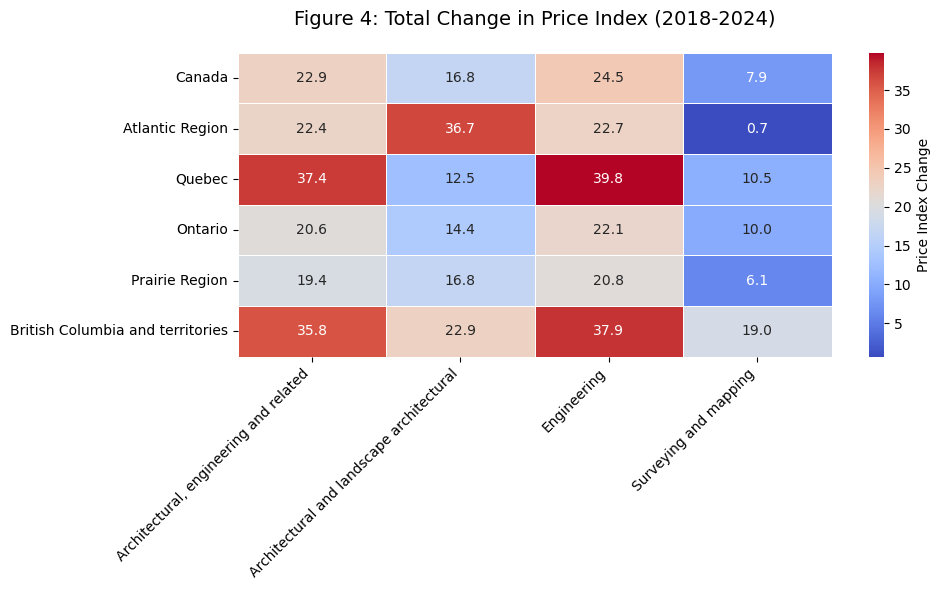

In [71]:
# Function to compute the total change in Index Value for each group
def total_change(group):
    group_sorted = group.sort_values("Date")
    return group_sorted["Index Value"].iloc[-1] - group_sorted["Index Value"].iloc[0]

# Group by Region and Service Category and apply total_change function
differences = aespi.groupby(["Region", "Service Category"], observed=False)[["Date", "Index Value"]].apply(total_change).reset_index(name="Diff")

# Create a new column with abbreviated service names for readability
differences["Service Category Short"] = differences["Service Category"].str.replace(r"\s*services.*$", "", regex=True)

# Define the order for shortened categories
short_category_order = [
    "Architectural, engineering and related",
    "Architectural and landscape architectural",
    "Engineering",
    "Surveying and mapping"
]

# Pivot
table = differences.pivot(index="Region", columns="Service Category Short", values="Diff")[short_category_order]

# Set color mapping boundaries based on data
vmin = np.nanmin(table.values)
vmax = np.nanmax(table.values)
center = (vmin + vmax) / 2

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    table,
    cmap="coolwarm",
    annot=True,
    fmt=".1f",
    center=center,
    linewidths=0.5,
    cbar_kws={"label": "Price Index Change"}
)
plt.xlabel("")
plt.ylabel("")
plt.title("Figure 4: Total Change in Price Index (2018-2024)", pad=20, fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('../analysis/figures/price_change_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

#### **Key Insights**  

##### **1. Aggregate Price Trends (first column)**
- **Highest Growth Regions**:  
  - **Quebec** (+37.4) and **British Columbia & Territories** (+35.8) led overall price increases, driven by major infrastructure projects and tight labor markets.  
  - These values exceed the national average (+22.9) by **53-63%**, highlighting acute regional cost pressures.
    <br>
- **Most Stable Regions**:  
  - **Prairie Region** (+19.4) and **Ontario** (+20.6) had more moderate overall increase compared to other regions. 

##### **2. Architectural Services Surge**  
- The **Atlantic Region**, where we previously observed two noticeable peaks in architectural services, shows the period's **highest sector increase** (+36.7) - more than double the national average (+16.8). This aligns with:  
  - **2020 Peak**: Post-Hurricane Fiona reconstruction needs  
  - **2024 Peak**: Federal affordable housing investments ($4B)  
  - **Ongoing Factors**:  
    - Climate-resilient coastal redesigns  
    - Healthcare infrastructure catch-up  

##### **3. Engineering Services Dominance**  
- **Quebec** (+39.8) and **BC & Territories** (+37.9) far surpassed the national average (+24.5), aligning with:  
  - Mega-projects (e.g., REM in Quebec, LNG Canada in BC)  
  - Engineering labor shortages in high-demand regions  

##### **4. Surveying Services Variations**  
- **Atlantic Region** (+0.7) showed the smallest sector change, reflecting:  
  - Fewer large-scale land surveys  
  - Public sector budget constraints  
<br>
- **BC & Territories** (+19.0) led regional increases, coinciding with:  
  - Resource sector expansion (mining/oil/gas mapping)  
  - Major infrastructure planning demands

---

## **4. Key Findings & Insights**

### **Synthesis of Observations**
1. **National Trends**
   - Overall index rose **22.9 points (2018–2024)**, tracking closely with CPI inflation.
   - **Engineering services** had the **sharpest national increase** (+24.5 points).
   - **Surveying/mapping services** saw the **smallest gains** nationally (+7.9).
<br><br>
2. **Regional Price Growth – Aggregate Index**
   - **Quebec & BC**: Highest jumps (Quebec +37.4, BC +35.8) driven by mega-projects (REM, LNG Canada).
   - **Ontario & Prairies**: More stable (Ontario +20.6, Prairies +19.4) due to diversified demand.
<br><br>
3. **Regional Variations**
   - **Architectural services**: Spiked in Atlantic Region (+36.7) post-2020 (climate/housing projects).
   - **Engineering**: Sharp increases in Quebec (+39.8) and BC & territories (+37.9) (mega-project demand).
   - **Surveying/mapping**: Near-flat in Atlantic Region (+0.7) (limited survey demand).

---

## 5. Interactive Dashboard: Dynamic Data Exploration

### 5.1. Overview
To extend the static visualizations from Section 3, I developed an **interactive dashboard** that integrates:
- The time-series **line plots**
- Year-over-year **bar charts**
- A **choropleth map** showing regional price differences


You can explore it directly online:  
👉 **[Launch Dashboard (AWS)](http://canada-service-prices.eba-syppj3bg.us-east-1.elasticbeanstalk.com/)**

Below is a screenshot of the dashboard.

![Interactive Dashboard](assets/interactive_dashboard.png)  

<p style="text-align: center;"><b>Figure 5: Interactive dashboard with dynamic filters for regions, services, and date ranges.</b></p>
<br>

---

### 5.2. The Value of Spatial Visualizations
The choropleth enhances analysis by:  
1. **Spatial Context**: Reveals regional price disparities at a glance
2. **Pattern Validation**: Confirms time-series trends geographically  
3. **Intuitive Interpretation**: Color gradients make relative differences immediately understandable

---

### 5.3. Technical Implementation and Access

#### 5.3.1. Dependencies
The dashboard was built using the following key Python libraries:

- `Plotly Dash`: for building interactive web components  
- `GeoPandas`: for reading and processing spatial GeoJSON data  
- `Plotly Express`: for fast and intuitive charting  

All dependencies are listed in [`environment.yml`](https://github.com/MathRC/canada-service-prices/blob/main/environment.yml).

#### 5.3.2. Interactive Functionality
The dashboard supports dynamic data exploration through:

- **Filter options**:  
  - Region (multi-select)  
  - Service category  
  - Date range (2018–2024)
<br><br>
- **Side-by-side comparisons**:  
  - View three charts simultaneously  
  - Compare national vs. regional pricing trends  
  - Visualize regional differences with a choropleth map  

#### 5.3.3. Access & Reproducibility

- **Live Dashboard**:  
  👉 [Launch Dashboard (AWS)](http://canada-service-prices.eba-syppj3bg.us-east-1.elasticbeanstalk.com/)
  
- **Codebase**:  
  Available in the [`/dashboard` directory](https://github.com/MathRC/canada-service-prices/tree/main/dashboard), which includes:
  - `app.py` (main application)
  - `assets/style.css` (custom styling)
<br><br>
- **Data Files**:  
  - [`aespi_clean.csv`](https://github.com/MathRC/canada-service-prices/blob/main/data/processed/aespi_clean.csv) – cleaned dataset
  - [`canada_regions.geojson`](https://github.com/MathRC/canada-service-prices/blob/main/data/processed/canada_regions.geojson) – region boundaries

- **Local Setup**:
  ```bash
  # 1. Clone and setup
  git clone https://github.com/MathRC/canada-service-prices.git
  cd canada-service-prices

  # 2. Create environment (from root)
  conda env create -f environment.yml
  conda activate aespi-env

  # 3. Launch dashboard
  cd dashboard
  python app.py  # Access at http://localhost:8050
  ```

---

## **6. Key Takeaways & Practical Applications**

### **Core Insights**
- Prices exhibited an **overall upward trend** with notable fluctuations, where Quebec and British Columbia saw both the most dramatic increases
- Notable sector-specific trends emerged:
  - Architectural services surged in the Atlantic Region
  - Engineering costs escalated sharply in Quebec and BC

### **Actionable Recommendations**
For **high-growth regions** (Quebec, BC):
- Consider multi-year contracts to mitigate price volatility
- Build additional cost contingencies into project budgets

For **Atlantic Region architectural services**:
- Align procurement with government funding cycles

### **Analysis Boundaries**
While the analysis reveals notable trends, it operates within specific limitations:  
- **Temporal granularity**: Quarterly aggregation may obscure monthly volatility  
- **Scope limitations**: External pricing factors (labor rates, material costs) were not included  
- **Regional groupings**: Broad geographic categories may mask local variations  

### **Why Predictive Analytics Was Not Applied**
While predictive modeling is a powerful data science tool, it wasn't appropriate for this analysis because of:
- **Fundamental unpredictability**: Trade policies, supply chain shocks, and economic crises introduce volatility that models can't reliably anticipate
- **Project focus**: This study prioritized identifying current trends over making speculative forecasts

*Note: I'm currently developing a separate portfolio project where predictive analytics are more suitable.*

### **Where Data Science Delivers Value**
This project demonstrates how analytical approaches can:
1. **Surface meaningful patterns** in regional and sector-specific pricing
2. **Support near-term decision making** through trend identification 
3. **Transform raw data** into clear, actionable visualizations

By focusing on observable trends rather than speculative forecasts, the analysis provides concrete insights while acknowledging economic realities.

---